## Data Pre-processing


Data cleaning has been done in part 1 and does not need to be performed again.


### Data Augmentation


In [1]:
from keras.preprocessing.image import ImageDataGenerator


def make_generators(input_shape, batch_size=32):
    train_gen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
    ).flow_from_directory(
        "data/train/",
        target_size=input_shape[:2],
        batch_size=batch_size,
        shuffle=True,
        interpolation="bicubic",  # A lot of images are resized with bicubic interpolation,
        # so use it in training as well to simulate real-world conditions
    )

    val_gen = ImageDataGenerator().flow_from_directory(
        "data/val/",
        target_size=input_shape[:2],
        shuffle=False,
        interpolation="bicubic",
    )

    test_gen = ImageDataGenerator().flow_from_directory(
        "data/test/",
        target_size=input_shape[:2],
        shuffle=False,
        interpolation="bicubic",
    )

    return train_gen, val_gen, test_gen

### Map data generator labels to "CommonName" column


In [2]:
import pandas as pd

labels_df = pd.read_csv("data/clean_labels.csv")
class_indices = {
    name: ImageDataGenerator()
    .flow_from_directory("data/train/")
    .class_indices[labels_df["Label"][i]]
    for i, name in enumerate(labels_df["CommonName"].unique())
}

Found 834 images belonging to 10 classes.


Found 834 images belonging to 10 classes.
Found 834 images belonging to 10 classes.
Found 834 images belonging to 10 classes.
Found 834 images belonging to 10 classes.
Found 834 images belonging to 10 classes.
Found 834 images belonging to 10 classes.
Found 834 images belonging to 10 classes.
Found 834 images belonging to 10 classes.
Found 834 images belonging to 10 classes.


## Models


In [3]:
from keras.layers import (
    GlobalAveragePooling2D,
    GlobalMaxPooling2D,
    Dense,
    Dropout,
    Lambda,
)
from keras.models import Sequential

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import classification_report


def plot_learning_curves(history):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["acc"])
    ax1.plot(history.history["val_acc"])
    ax1.set_title("Accuracy")
    ax1.set(xlabel="Epoch", ylabel="Accuracy")
    ax1.legend(["train", "validation"], loc="lower right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax2.plot(history.history["loss"])
    ax2.plot(history.history["val_loss"])
    ax2.set_title("Loss")
    ax2.set(xlabel="Epoch", ylabel="Loss")
    ax2.legend(["train", "validation"], loc="upper right")
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))


def print_classification_report(model, test_gen):
    y_pred = model.predict(test_gen, verbose=0)
    y_pred = y_pred.argmax(axis=1)
    print(
        classification_report(
            test_gen.classes,
            y_pred,
            target_names=class_indices,
            digits=3,
        )
    )
    print(f"Loss: {model.evaluate(test_gen, verbose=0)[0]:.4f}")

In [5]:
import tensorflow as tf


# Save to tflite format for androind application
def save_model(model, name):
    tf.saved_model.save(model, f"models/{name}/")
    converter = tf.lite.TFLiteConverter.from_saved_model(f"models/{name}/")
    tflite_model = converter.convert()
    with open(f"models/{name}.tflite", "wb") as f:
        f.write(tflite_model)

### Model 1: InceptionV3 (98.6% acc, 0.0238 loss)


In [6]:
# Use default input shape for InceptionV3
# https://keras.io/api/applications/inceptionv3/
INPUT_SHAPE = (299, 299, 3)
train_gen, val_gen, test_gen = make_generators(INPUT_SHAPE)

Found 834 images belonging to 10 classes.
Found 236 images belonging to 10 classes.
Found 127 images belonging to 10 classes.


In [7]:
from keras.applications import InceptionV3
import keras.applications.inception_v3 as inception_v3

base_model = InceptionV3(include_top=False, weights="imagenet", input_shape=INPUT_SHAPE)
base_model.trainable = False

inception_model = Sequential(
    [
        Lambda(inception_v3.preprocess_input, input_shape=INPUT_SHAPE),
        base_model,
        GlobalAveragePooling2D(),
        Dense(train_gen.num_classes, activation="softmax"),
    ]
)

inception_model.build()
inception_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________


In [8]:
from keras.callbacks import EarlyStopping

inception_model.compile(
    # lowering the learning rate or using a learning rate scheduler appears to only
    # slow down training
    #    Adam: 0.0347 test loss in 22 epochs
    #  Adamax: 0.0441 test loss in 48 epochs
    # Rmsprop: 0.0317 test loss in 9 epochs
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["acc"],
)

early_stopping = EarlyStopping(
    monitor="val_loss", patience=2, restore_best_weights=True
)

history = inception_model.fit(
    train_gen,
    epochs=100,
    callbacks=[early_stopping],
    validation_data=val_gen,
    workers=4,  # Use 4 CPU cores to reduce the CPU bottleneck from image augmentation
)

Epoch 1/100
27/27 [==============================] - 21s 469ms/step - loss: 1.0234 - acc: 0.7782 - val_loss: 0.4034 - val_acc: 0.9746
Epoch 2/100
27/27 [==============================] - 11s 371ms/step - loss: 0.3051 - acc: 0.9712 - val_loss: 0.2020 - val_acc: 0.9831
Epoch 3/100
27/27 [==============================] - 11s 384ms/step - loss: 0.1732 - acc: 0.9688 - val_loss: 0.1303 - val_acc: 0.9831
Epoch 4/100
27/27 [==============================] - 11s 362ms/step - loss: 0.1080 - acc: 0.9820 - val_loss: 0.0839 - val_acc: 0.9873
Epoch 5/100
27/27 [==============================] - 11s 377ms/step - loss: 0.0781 - acc: 0.9868 - val_loss: 0.0649 - val_acc: 0.9873
Epoch 6/100
27/27 [==============================] - 11s 363ms/step - loss: 0.0616 - acc: 0.9892 - val_loss: 0.0532 - val_acc: 0.9915
Epoch 7/100
27/27 [==============================] - 12s 391ms/step - loss: 0.0506 - acc: 0.9892 - val_loss: 0.0538 - val_acc: 0.9915
Epoch 8/100
27/27 [==============================] - 12s 383ms

                           precision    recall  f1-score   support

           Mantled Howler      1.000     0.917     0.957        12
             Patas Monkey      1.000     1.000     1.000        13
              Bald Uakari      1.000     0.923     0.960        13
         Japanese Macaque      1.000     1.000     1.000        15
           Pygmy Marmoset      1.000     1.000     1.000        13
    White Headed Capuchin      1.000     1.000     1.000        13
         Silvery Marmoset      1.000     1.000     1.000        11
   Common Squirrel Monkey      1.000     1.000     1.000        14
Black Headed Night Monkey      0.917     1.000     0.957        11
           Nilgiri Langur      0.923     1.000     0.960        12

                 accuracy                          0.984       127
                macro avg      0.984     0.984     0.983       127
             weighted avg      0.986     0.984     0.984       127

Loss: 0.0238


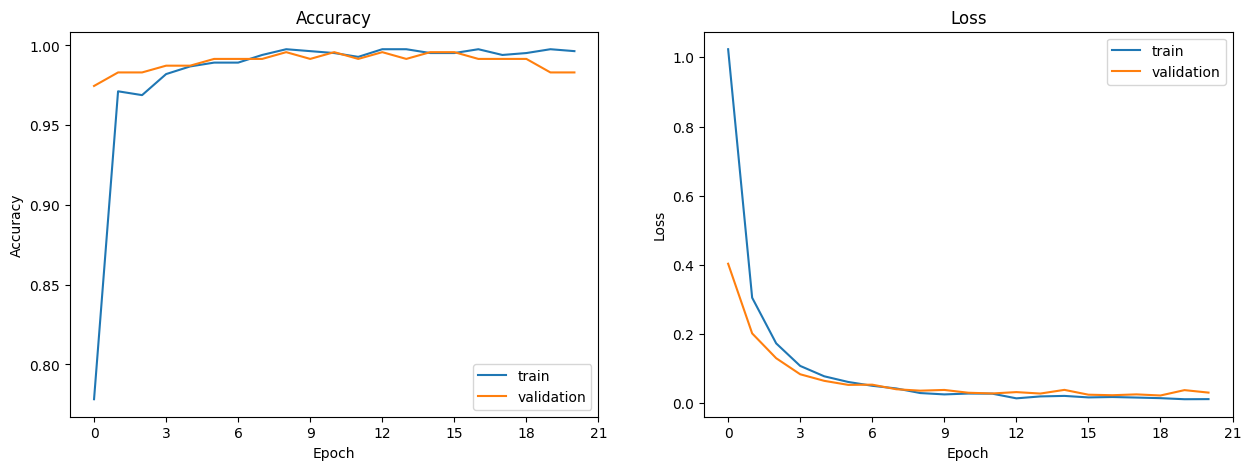

In [9]:
print_classification_report(inception_model, test_gen)
plot_learning_curves(history)

### Model 2: Xception (99.3% acc, 0.0303 loss)


In [10]:
# Use default input shape for Xception
# https://keras.io/api/applications/xception/
INPUT_SHAPE = (299, 299, 3)
train_gen, val_gen, test_gen = make_generators(INPUT_SHAPE)

Found 834 images belonging to 10 classes.
Found 236 images belonging to 10 classes.
Found 127 images belonging to 10 classes.


In [11]:
from keras.applications import Xception
import keras.applications.xception as xception

base_model = Xception(include_top=False, weights="imagenet", input_shape=INPUT_SHAPE)
base_model.trainable = False

xception_model = Sequential(
    [
        Lambda(xception.preprocess_input, input_shape=INPUT_SHAPE),
        base_model,
        GlobalAveragePooling2D(),
        Dense(train_gen.num_classes, activation="softmax"),
    ]
)

xception_model.build()
xception_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 10)                20490     
                                                                 
Total params: 20,881,970
Trainable params: 20,490
Non-trainable params: 20,861,480
_________________________________________________________________


In [12]:
from keras.callbacks import EarlyStopping

xception_model.compile(
    # lowering the learning rate or using a learning rate scheduler appears to only
    # slow down training
    #    Adam: 0.0338 test loss in 22 epochs
    # Adagrad: 0.2917 test loss in 100 epochs
    #  Adamax: 0.0387 test loss in 78 epochs
    #   Nadam: 0.0273 test loss in 30 epochs
    # Rmsprop: 0.0188 test loss in 19 epochs
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["acc"],
)

early_stopping = EarlyStopping(
    monitor="val_loss", patience=2, restore_best_weights=True
)

history = xception_model.fit(
    train_gen,
    epochs=100,
    callbacks=[early_stopping],
    validation_data=val_gen,
    workers=4,  # Use 4 CPU cores to reduce the CPU bottleneck from image augmentation
)

Epoch 1/100
27/27 [==============================] - 18s 560ms/step - loss: 1.2935 - acc: 0.7818 - val_loss: 0.6482 - val_acc: 0.9831
Epoch 2/100
27/27 [==============================] - 12s 410ms/step - loss: 0.4481 - acc: 0.9856 - val_loss: 0.2770 - val_acc: 0.9915
Epoch 3/100
27/27 [==============================] - 12s 382ms/step - loss: 0.2195 - acc: 0.9928 - val_loss: 0.1490 - val_acc: 0.9831
Epoch 4/100
27/27 [==============================] - 13s 398ms/step - loss: 0.1184 - acc: 0.9916 - val_loss: 0.0938 - val_acc: 0.9873
Epoch 5/100
27/27 [==============================] - 13s 422ms/step - loss: 0.0758 - acc: 0.9940 - val_loss: 0.0671 - val_acc: 0.9915
Epoch 6/100
27/27 [==============================] - 12s 374ms/step - loss: 0.0569 - acc: 0.9964 - val_loss: 0.0584 - val_acc: 0.9873
Epoch 7/100
27/27 [==============================] - 13s 424ms/step - loss: 0.0381 - acc: 0.9988 - val_loss: 0.0438 - val_acc: 0.9958
Epoch 8/100
27/27 [==============================] - 12s 430ms

                           precision    recall  f1-score   support

           Mantled Howler      1.000     1.000     1.000        12
             Patas Monkey      1.000     1.000     1.000        13
              Bald Uakari      1.000     1.000     1.000        13
         Japanese Macaque      0.938     1.000     0.968        15
           Pygmy Marmoset      1.000     1.000     1.000        13
    White Headed Capuchin      1.000     1.000     1.000        13
         Silvery Marmoset      1.000     0.909     0.952        11
   Common Squirrel Monkey      1.000     1.000     1.000        14
Black Headed Night Monkey      1.000     1.000     1.000        11
           Nilgiri Langur      1.000     1.000     1.000        12

                 accuracy                          0.992       127
                macro avg      0.994     0.991     0.992       127
             weighted avg      0.993     0.992     0.992       127

Loss: 0.0303


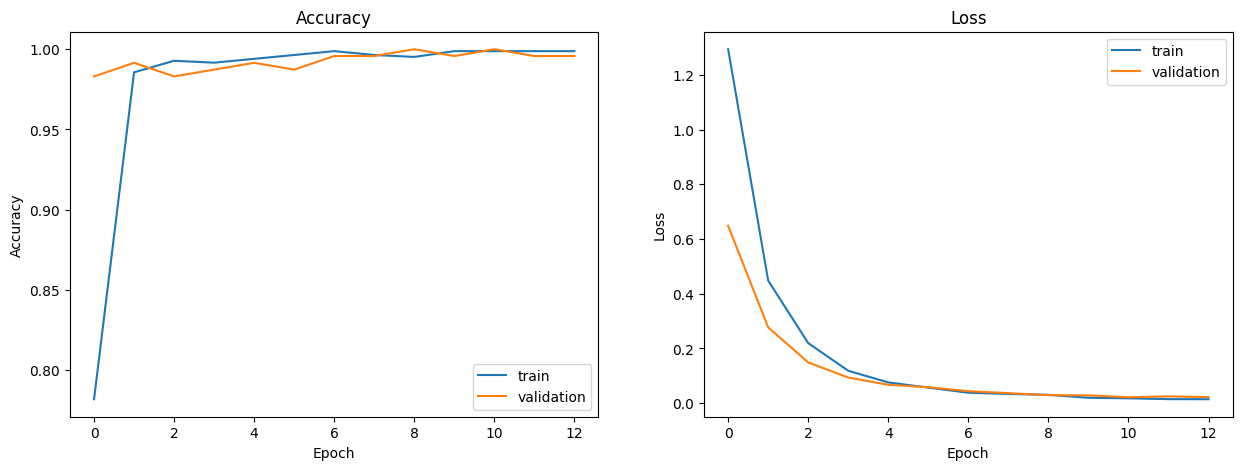

In [13]:
print_classification_report(xception_model, test_gen)
plot_learning_curves(history)

### Model 3: EfficientNetB2 (100% acc, 0.0005 loss)


In [14]:
# Input sizes that are multiples of 32 are recommended due to the architecture of EfficientNetB3
# With optimiser RMSprop with default parameters:
# INPUT_SHAPE = (160, 160, 3)  # 0.0257 test loss in 25 epochs
# INPUT_SHAPE = (256, 256, 3)  # 0.0025 test loss in 14 epochs
# INPUT_SHAPE = (288, 288, 3)  # 0.0011 test loss in 41 epochs
# INPUT_SHAPE = (320, 320, 3)  # 0.0010 test loss in 40 epochs
INPUT_SHAPE = (352, 352, 3)  # 0.0005 test loss in 21 epochs
# INPUT_SHAPE = (384, 384, 3)  # 0.0012 test loss in 19 epochs
train_gen, val_gen, test_gen = make_generators(INPUT_SHAPE)

Found 834 images belonging to 10 classes.
Found 236 images belonging to 10 classes.
Found 127 images belonging to 10 classes.


In [15]:
from keras.applications import EfficientNetB2
import keras.applications.efficientnet as efficientnet

base_model = EfficientNetB2(
    include_top=False, weights="imagenet", input_shape=INPUT_SHAPE
)
base_model.trainable = False

efficientnet_model = Sequential(
    [
        Lambda(efficientnet.preprocess_input, input_shape=INPUT_SHAPE),
        base_model,
        GlobalAveragePooling2D(),
        Dense(train_gen.num_classes, activation="softmax"),
    ]
)

efficientnet_model.build()
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 352, 352, 3)       0         
                                                                 
 efficientnetb2 (Functional)  (None, 11, 11, 1408)     7768569   
                                                                 
 global_average_pooling2d_2   (None, 1408)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 10)                14090     
                                                                 
Total params: 7,782,659
Trainable params: 14,090
Non-trainable params: 7,768,569
_________________________________________________________________


In [16]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import RMSprop

efficientnet_model.compile(
    # With input shape (160, 160, 3) and initial learning rate 1e-3:
    # RMSprop: 0.0257 test loss in 25 epochs
    #    Adam: 0.0289 test loss in 37 epochs
    #  Adamax: 0.0413 test loss in 100 epochs
    # Using a higher learning rate appears to speed up learning without
    # sacrificing performance for larger image sizes
    optimizer=RMSprop(learning_rate=2e-3),
    loss="categorical_crossentropy",
    metrics=["acc"],
)

early_stopping = EarlyStopping(
    monitor="val_loss", patience=7, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=5e-4)

history = efficientnet_model.fit(
    train_gen,
    epochs=100,
    callbacks=[early_stopping, reduce_lr],
    validation_data=val_gen,
    workers=4,  # Use 4 CPU cores to reduce the CPU bottleneck from image augmentation
)

Epoch 1/100
27/27 [==============================] - 27s 607ms/step - loss: 0.7351 - acc: 0.8861 - val_loss: 0.1869 - val_acc: 0.9958 - lr: 0.0020
Epoch 2/100
27/27 [==============================] - 14s 444ms/step - loss: 0.1547 - acc: 0.9856 - val_loss: 0.0659 - val_acc: 1.0000 - lr: 0.0020
Epoch 3/100
27/27 [==============================] - 15s 484ms/step - loss: 0.0669 - acc: 0.9952 - val_loss: 0.0365 - val_acc: 1.0000 - lr: 0.0020
Epoch 4/100
27/27 [==============================] - 13s 414ms/step - loss: 0.0377 - acc: 0.9964 - val_loss: 0.0211 - val_acc: 1.0000 - lr: 0.0020
Epoch 5/100
27/27 [==============================] - 14s 434ms/step - loss: 0.0170 - acc: 1.0000 - val_loss: 0.0162 - val_acc: 0.9958 - lr: 0.0020
Epoch 6/100
27/27 [==============================] - 14s 472ms/step - loss: 0.0126 - acc: 1.0000 - val_loss: 0.0119 - val_acc: 1.0000 - lr: 0.0020
Epoch 7/100
27/27 [==============================] - 13s 417ms/step - loss: 0.0082 - acc: 1.0000 - val_loss: 0.0131 - 

                           precision    recall  f1-score   support

           Mantled Howler      1.000     1.000     1.000        12
             Patas Monkey      1.000     1.000     1.000        13
              Bald Uakari      1.000     1.000     1.000        13
         Japanese Macaque      1.000     1.000     1.000        15
           Pygmy Marmoset      1.000     1.000     1.000        13
    White Headed Capuchin      1.000     1.000     1.000        13
         Silvery Marmoset      1.000     1.000     1.000        11
   Common Squirrel Monkey      1.000     1.000     1.000        14
Black Headed Night Monkey      1.000     1.000     1.000        11
           Nilgiri Langur      1.000     1.000     1.000        12

                 accuracy                          1.000       127
                macro avg      1.000     1.000     1.000       127
             weighted avg      1.000     1.000     1.000       127

Loss: 0.0005


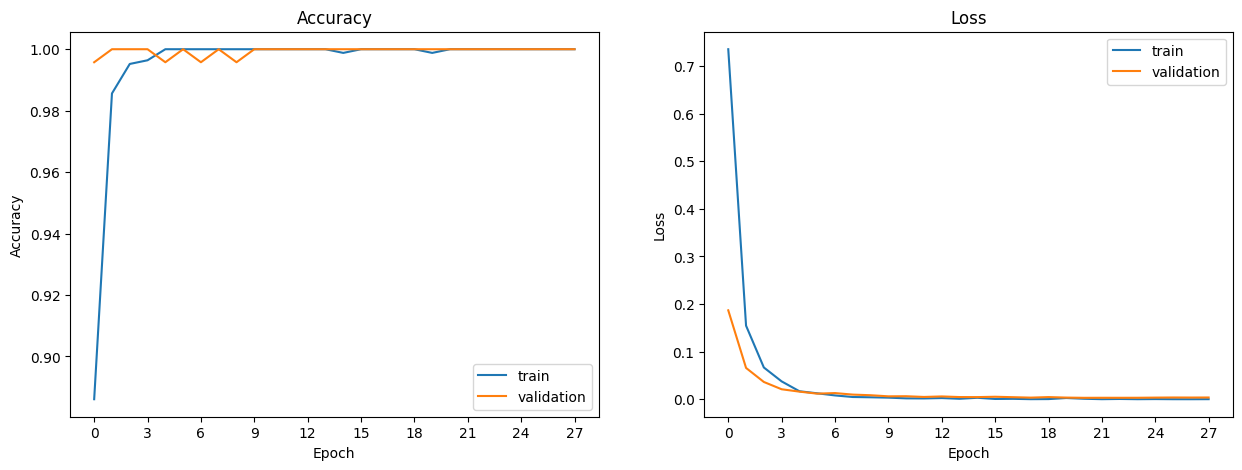

In [17]:
print_classification_report(efficientnet_model, test_gen)
plot_learning_curves(history)

### Model 4: EfficientNetV2B1 (100% acc, 0.0007 loss)


In [18]:
# Input sizes that are multiples of 32 are recommended due to the architecture of EfficientNetV2B1
# With optimiser RMSprop with default parameters:
# INPUT_SHAPE = (160, 160, 3)  # 0.0144 test loss in 21 epochs
# INPUT_SHAPE = (224, 224, 3)  # 0.0049 test loss in 16 epochs
# INPUT_SHAPE = (288, 288, 3)  # 0.0034 test loss in 17 epochs
INPUT_SHAPE = (320, 320, 3)  # 0.0007 test loss in 19 epochs
# INPUT_SHAPE = (352, 352, 3)  # 0.0017 test loss in 39 epochs
train_gen, val_gen, test_gen = make_generators(INPUT_SHAPE)

Found 834 images belonging to 10 classes.
Found 236 images belonging to 10 classes.
Found 127 images belonging to 10 classes.


In [19]:
from keras.applications import EfficientNetV2B1
import keras.applications.efficientnet_v2 as efficientnet_v2

base_model = EfficientNetV2B1(
    include_top=False, weights="imagenet", input_shape=INPUT_SHAPE
)
base_model.trainable = False

efficientnetv2_model = Sequential(
    [
        Lambda(efficientnet_v2.preprocess_input, input_shape=INPUT_SHAPE),
        base_model,
        GlobalAveragePooling2D(),
        Dense(train_gen.num_classes, activation="softmax"),
    ]
)

efficientnetv2_model.build()
efficientnetv2_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           (None, 320, 320, 3)       0         
                                                                 
 efficientnetv2-b1 (Function  (None, 10, 10, 1280)     6931124   
 al)                                                             
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 10)                12810     
                                                                 
Total params: 6,943,934
Trainable params: 12,810
Non-trainable params: 6,931,124
_________________________________________________________________


In [20]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import RMSprop

efficientnetv2_model.compile(
    # With input size of (320, 320, 3) and initial learning rate 1e-3:
    # RMSprop: 0.0011 test loss in 37 epochs
    #    Adam: 0.0081 test loss in 38 epochs
    #  Adamax: 0.0030 test loss in 100 epochs
    optimizer=RMSprop(learning_rate=2e-3),
    loss="categorical_crossentropy",
    metrics=["acc"],
)

early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=5e-4)

history = efficientnetv2_model.fit(
    train_gen,
    epochs=100,
    callbacks=[early_stopping, reduce_lr],
    validation_data=val_gen,
    workers=4,  # Use 4 CPU cores to reduce the CPU bottleneck from image augmentation
)

Epoch 1/100
27/27 [==============================] - 23s 509ms/step - loss: 0.7211 - acc: 0.8909 - val_loss: 0.1845 - val_acc: 0.9915 - lr: 0.0020
Epoch 2/100
27/27 [==============================] - 11s 384ms/step - loss: 0.1576 - acc: 0.9892 - val_loss: 0.0721 - val_acc: 0.9915 - lr: 0.0020
Epoch 3/100
27/27 [==============================] - 12s 379ms/step - loss: 0.0793 - acc: 0.9868 - val_loss: 0.0383 - val_acc: 0.9915 - lr: 0.0020
Epoch 4/100
27/27 [==============================] - 12s 390ms/step - loss: 0.0380 - acc: 0.9976 - val_loss: 0.0333 - val_acc: 0.9915 - lr: 0.0020
Epoch 5/100
27/27 [==============================] - 12s 462ms/step - loss: 0.0329 - acc: 0.9940 - val_loss: 0.0197 - val_acc: 0.9915 - lr: 0.0020
Epoch 6/100
27/27 [==============================] - 12s 401ms/step - loss: 0.0201 - acc: 0.9976 - val_loss: 0.0180 - val_acc: 0.9915 - lr: 0.0020
Epoch 7/100
27/27 [==============================] - 12s 408ms/step - loss: 0.0170 - acc: 0.9964 - val_loss: 0.0131 - 

                           precision    recall  f1-score   support

           Mantled Howler      1.000     1.000     1.000        12
             Patas Monkey      1.000     1.000     1.000        13
              Bald Uakari      1.000     1.000     1.000        13
         Japanese Macaque      1.000     1.000     1.000        15
           Pygmy Marmoset      1.000     1.000     1.000        13
    White Headed Capuchin      1.000     1.000     1.000        13
         Silvery Marmoset      1.000     1.000     1.000        11
   Common Squirrel Monkey      1.000     1.000     1.000        14
Black Headed Night Monkey      1.000     1.000     1.000        11
           Nilgiri Langur      1.000     1.000     1.000        12

                 accuracy                          1.000       127
                macro avg      1.000     1.000     1.000       127
             weighted avg      1.000     1.000     1.000       127

Loss: 0.0007


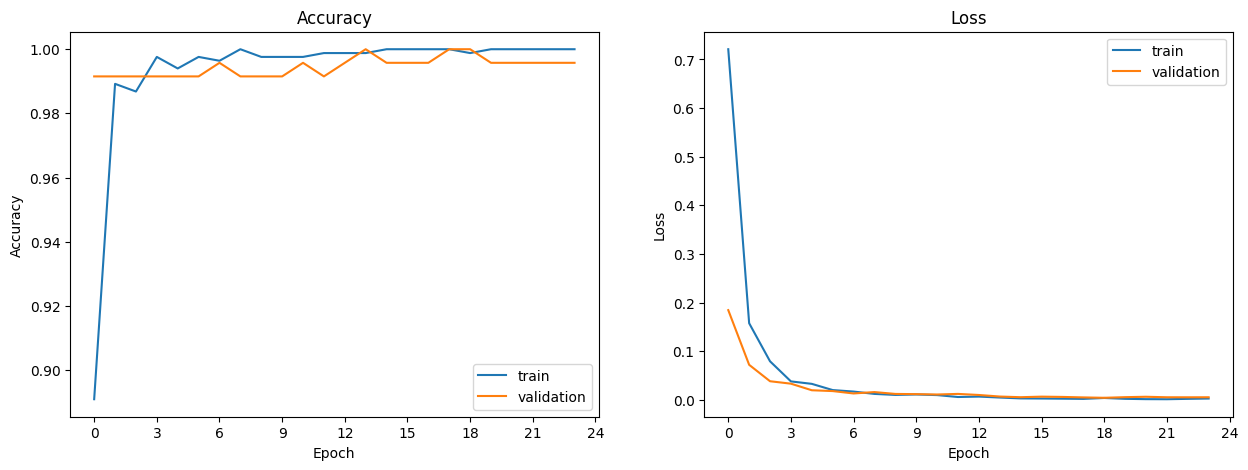

In [21]:
print_classification_report(efficientnetv2_model, test_gen)
plot_learning_curves(history)

### Model 5: ResNet50V2 (No hypertuning, 92.2% acc, 0.7279 loss)


In [22]:
# Use default shape of (224, 224)
# https://stackoverflow.com/a/68696844
INPUT_SHAPE = (224, 224, 3)
train_gen, val_gen, test_gen = make_generators(INPUT_SHAPE)

Found 834 images belonging to 10 classes.
Found 236 images belonging to 10 classes.
Found 127 images belonging to 10 classes.


In [23]:
from keras.applications import ResNet50V2
import keras.applications.resnet_v2 as resnet_v2

base_model = ResNet50V2(include_top=False, weights="imagenet", input_shape=INPUT_SHAPE)
base_model.trainable = False

resnetv2_model = Sequential(
    [
        Lambda(resnet_v2.preprocess_input, input_shape=INPUT_SHAPE),
        base_model,
        GlobalMaxPooling2D(),
        Dense(train_gen.num_classes, activation="softmax"),
    ]
)

resnetv2_model.build()
resnetv2_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense_4 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [24]:
from keras.callbacks import EarlyStopping

resnetv2_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["acc"],
)

early_stopping = EarlyStopping(
    monitor="val_loss", patience=2, restore_best_weights=True
)

history = resnetv2_model.fit(
    train_gen,
    epochs=100,
    callbacks=[early_stopping],
    validation_data=val_gen,
    workers=4,  # Use 4 CPU cores to reduce the CPU bottleneck from image augmentation
)

Epoch 1/100
27/27 [==============================] - 14s 355ms/step - loss: 6.3302 - acc: 0.4520 - val_loss: 1.1351 - val_acc: 0.8220
Epoch 2/100
27/27 [==============================] - 9s 291ms/step - loss: 1.1486 - acc: 0.8561 - val_loss: 0.7509 - val_acc: 0.8898
Epoch 3/100
27/27 [==============================] - 9s 307ms/step - loss: 0.5449 - acc: 0.9053 - val_loss: 0.5618 - val_acc: 0.9195
Epoch 4/100
27/27 [==============================] - 9s 326ms/step - loss: 0.4979 - acc: 0.9221 - val_loss: 0.4910 - val_acc: 0.9449
Epoch 5/100
27/27 [==============================] - 9s 294ms/step - loss: 0.4734 - acc: 0.9317 - val_loss: 0.3802 - val_acc: 0.9534
Epoch 6/100
27/27 [==============================] - 9s 299ms/step - loss: 0.2499 - acc: 0.9532 - val_loss: 0.4868 - val_acc: 0.9364
Epoch 7/100
27/27 [==============================] - 9s 319ms/step - loss: 0.5845 - acc: 0.9221 - val_loss: 0.5044 - val_acc: 0.9364


                           precision    recall  f1-score   support

           Mantled Howler      0.786     0.917     0.846        12
             Patas Monkey      1.000     0.923     0.960        13
              Bald Uakari      1.000     0.846     0.917        13
         Japanese Macaque      0.867     0.867     0.867        15
           Pygmy Marmoset      0.929     1.000     0.963        13
    White Headed Capuchin      0.929     1.000     0.963        13
         Silvery Marmoset      0.909     0.909     0.909        11
   Common Squirrel Monkey      0.824     1.000     0.903        14
Black Headed Night Monkey      1.000     0.909     0.952        11
           Nilgiri Langur      1.000     0.750     0.857        12

                 accuracy                          0.913       127
                macro avg      0.924     0.912     0.914       127
             weighted avg      0.922     0.913     0.913       127

Loss: 0.7279


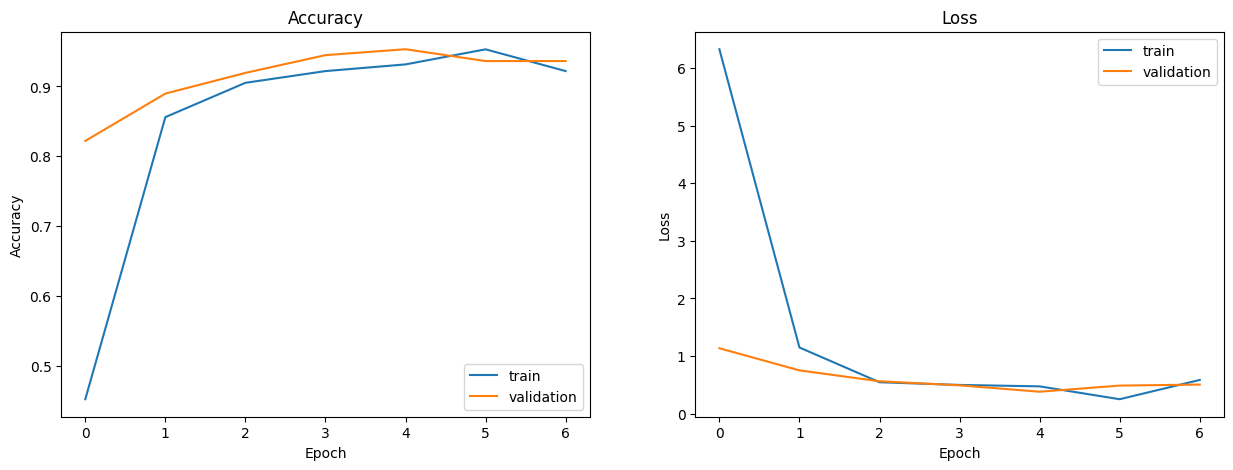

In [25]:
print_classification_report(resnetv2_model, test_gen)
plot_learning_curves(history)

### Model 6: ResNet50V2 (Hypertuned, 100% acc, 0.0055 loss)


In [26]:
# Input sizes that are multiples of 32 are recommended due to the architecture of ResNet50V2
# With optimiser RMSprop with default parameters:
# INPUT_SHAPE = (256, 256, 3)  # 0.0555 test loss in 7 epochs
# INPUT_SHAPE = (320, 320, 3)  # 0.0285 test loss in 15 epochs
# INPUT_SHAPE = (384, 384, 3)  # 0.0118 test loss in 31 epochs
INPUT_SHAPE = (416, 416, 3)  # 0.0038 test loss in 23 epochs
train_gen, val_gen, test_gen = make_generators(INPUT_SHAPE)

Found 834 images belonging to 10 classes.
Found 236 images belonging to 10 classes.
Found 127 images belonging to 10 classes.


In [27]:
from keras.applications import ResNet50V2
import keras.applications.resnet_v2 as resnet_v2

base_model = ResNet50V2(include_top=False, weights="imagenet", input_shape=INPUT_SHAPE)
base_model.trainable = False

resnetv2_hypertuned_model = Sequential(
    [
        Lambda(resnet_v2.preprocess_input, input_shape=INPUT_SHAPE),
        base_model,
        # Average pooling retains more information than max pooling and is thus
        # better suited as one of the last few layers where a lot of information
        # is important and should not be discarded
        GlobalAveragePooling2D(),
        # Add more learning capacity to classifier
        Dense(32, activation="gelu"),
        # Untuned model started overfitting near the end, add some dropout to
        # prevent that
        Dropout(0.2),
        Dense(train_gen.num_classes, activation="softmax"),
    ]
)

resnetv2_hypertuned_model.build()
resnetv2_hypertuned_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_7 (Lambda)           (None, 416, 416, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 13, 13, 2048)      23564800  
                                                                 
 global_average_pooling2d_6   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 32)                65568     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                330       
                                                      

In [28]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

resnetv2_hypertuned_model.compile(
    # For input size of (256, 256, 3):
    #    Adam: 0.0694 test loss in 9 epochs
    #  Adamax: 0.0597 test loss in 19 epochs
    # RMSprop: 0.0555 test loss in 7 epochs
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["acc"],
)

early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=5e-4)

history = resnetv2_hypertuned_model.fit(
    train_gen,
    epochs=100,
    callbacks=[early_stopping, reduce_lr],
    validation_data=val_gen,
    workers=4,  # Use 4 CPU cores to reduce the CPU bottleneck from image augmentation
)

Epoch 1/100
27/27 [==============================] - 22s 628ms/step - loss: 1.3632 - acc: 0.5947 - val_loss: 0.5951 - val_acc: 0.9153 - lr: 0.0010
Epoch 2/100
27/27 [==============================] - 17s 548ms/step - loss: 0.5353 - acc: 0.8921 - val_loss: 0.2480 - val_acc: 0.9873 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - 16s 531ms/step - loss: 0.2929 - acc: 0.9508 - val_loss: 0.1322 - val_acc: 0.9831 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - 17s 561ms/step - loss: 0.1880 - acc: 0.9664 - val_loss: 0.0870 - val_acc: 0.9915 - lr: 0.0010
Epoch 5/100
27/27 [==============================] - 16s 529ms/step - loss: 0.1401 - acc: 0.9760 - val_loss: 0.0601 - val_acc: 0.9958 - lr: 0.0010
Epoch 6/100
27/27 [==============================] - 16s 539ms/step - loss: 0.0941 - acc: 0.9844 - val_loss: 0.0439 - val_acc: 0.9958 - lr: 0.0010
Epoch 7/100
27/27 [==============================] - 16s 543ms/step - loss: 0.0779 - acc: 0.9868 - val_loss: 0.0418 - 

                           precision    recall  f1-score   support

           Mantled Howler      1.000     1.000     1.000        12
             Patas Monkey      1.000     1.000     1.000        13
              Bald Uakari      1.000     1.000     1.000        13
         Japanese Macaque      1.000     1.000     1.000        15
           Pygmy Marmoset      1.000     1.000     1.000        13
    White Headed Capuchin      1.000     1.000     1.000        13
         Silvery Marmoset      1.000     1.000     1.000        11
   Common Squirrel Monkey      1.000     1.000     1.000        14
Black Headed Night Monkey      1.000     1.000     1.000        11
           Nilgiri Langur      1.000     1.000     1.000        12

                 accuracy                          1.000       127
                macro avg      1.000     1.000     1.000       127
             weighted avg      1.000     1.000     1.000       127

Loss: 0.0055


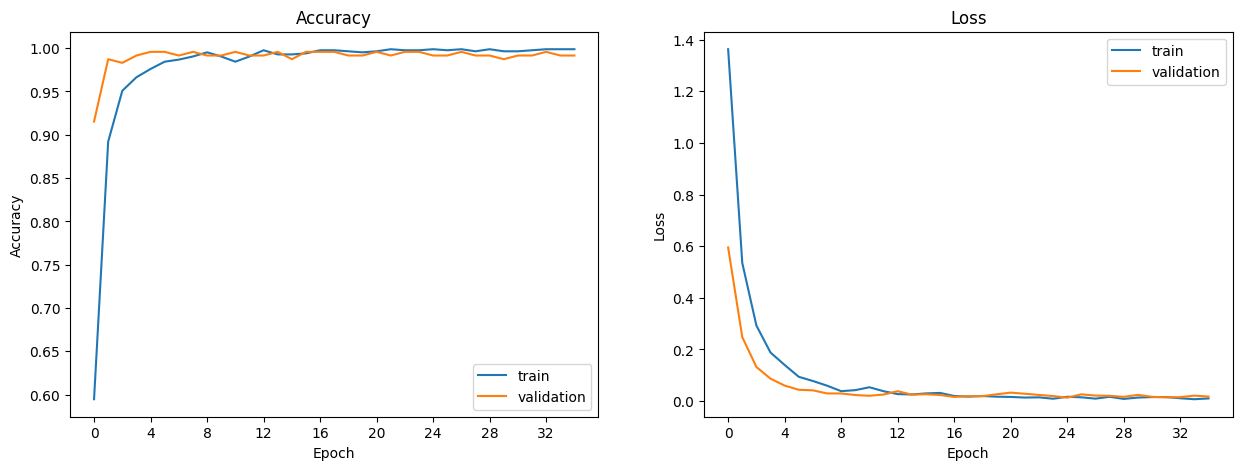

In [29]:
print_classification_report(resnetv2_hypertuned_model, test_gen)
plot_learning_curves(history)

### Save model


In [30]:
from IPython.display import clear_output

shapes = [
    (192, 192, 3),
    (224, 224, 3),
    (256, 256, 3),
    (288, 288, 3),
    (320, 320, 3),
    (352, 352, 3),
]
v1_metrics = []
v2_metrics = []

# See which input shape works best
for input_shape in shapes:
    _, _, test_gen = make_generators(input_shape)
    # Clear output to remove clutter from instantiating data generators
    clear_output()

    # EfficientNetB2
    base_model = EfficientNetB2(
        include_top=False, weights="imagenet", input_shape=input_shape
    )
    model = Sequential(
        [
            Lambda(efficientnet.preprocess_input, input_shape=input_shape),
            base_model,
            GlobalAveragePooling2D(),  # Global pooling ensures that the dense layer always has the
            # same input shape, so we can use any input size of at least 32x32
            Dense(test_gen.num_classes, activation="softmax"),
        ]
    )
    model.set_weights(efficientnet_model.get_weights())
    model.compile(
        loss="categorical_crossentropy",
        metrics=["acc"],
    )
    v1_metrics.append(model.evaluate(test_gen, verbose=0))

    # EfficientNetV2B1
    base_model = EfficientNetV2B1(
        include_top=False, weights="imagenet", input_shape=input_shape
    )
    model = Sequential(
        [
            Lambda(efficientnet_v2.preprocess_input, input_shape=input_shape),
            base_model,
            GlobalAveragePooling2D(),  # Global pooling ensures that the dense layer always has the
            # same input shape, so we can use any input size of at least 32x32
            Dense(test_gen.num_classes, activation="softmax"),
        ]
    )
    model.set_weights(efficientnetv2_model.get_weights())
    model.compile(
        loss="categorical_crossentropy",
        metrics=["acc"],
    )
    v2_metrics.append(model.evaluate(test_gen, verbose=0))

print("EfficientNetB2:")
for input_shape, metrics in zip(shapes, v1_metrics):
    print(
        f"Input shape: {input_shape} | loss: {metrics[0]:.4f} | acc: {metrics[1]:.4f}"
    )
print("\nEfficientNetV2B1:")
for input_shape, metrics in zip(shapes, v2_metrics):
    print(
        f"Input shape: {input_shape} | loss: {metrics[0]:.4f} | acc: {metrics[1]:.4f}"
    )

EfficientNetB2:
Input shape: (192, 192, 3) | loss: 0.0210 | acc: 0.9843
Input shape: (224, 224, 3) | loss: 0.0093 | acc: 0.9921
Input shape: (256, 256, 3) | loss: 0.0008 | acc: 1.0000
Input shape: (288, 288, 3) | loss: 0.0008 | acc: 1.0000
Input shape: (320, 320, 3) | loss: 0.0013 | acc: 1.0000
Input shape: (352, 352, 3) | loss: 0.0005 | acc: 1.0000

EfficientNetV2B1:
Input shape: (192, 192, 3) | loss: 0.0034 | acc: 1.0000
Input shape: (224, 224, 3) | loss: 0.0011 | acc: 1.0000
Input shape: (256, 256, 3) | loss: 0.0014 | acc: 1.0000
Input shape: (288, 288, 3) | loss: 0.0015 | acc: 1.0000
Input shape: (320, 320, 3) | loss: 0.0007 | acc: 1.0000
Input shape: (352, 352, 3) | loss: 0.0010 | acc: 1.0000


Out of all the models trained, the EfficientNet models have the highest accuracy and lowest loss, clearly making them the best performing models. However, since the models are to be deployed to an android app, where computational power is limited, inference time is also an important factor to consider.

The EfficientNetV2B1 model has the lowest number of parameters out of all the models, and also performs well on smaller image sizes (better than when trained on those sizes directly, interestingly).
As such, I have decided that the best compromise between accuracy and inference time is the EfficientNetV2B1 model with 224x224 RGB input. It is computationally efficient, while achieving 100% accuracy on the test set, a great improvement compared to the baseline model's 81.89%.


In [31]:
INPUT_SHAPE = (224, 224, 3)
base_model = EfficientNetV2B1(
    include_top=False, weights="imagenet", input_shape=INPUT_SHAPE
)
final_model = Sequential(
    [
        Lambda(efficientnet_v2.preprocess_input, input_shape=INPUT_SHAPE),
        base_model,
        GlobalAveragePooling2D(),
        Dense(test_gen.num_classes, activation="softmax"),
    ]
)
final_model.set_weights(efficientnetv2_model.get_weights())
save_model(final_model, "efficientnetv2_224_final")

## Additional notes


All models used cross entropy loss, meaning that their relative performance can, and should, be compared by their loss values, as that provides a more precise measure than accuracy. This is due to the fact that accuracy is discrete (true/false for each sample), while loss is continuous (a real number for each sample).


The extremely low test losses scored by the EfficientNetB2, EfficientNetV2B1 and ResNet50V2 models are unusual, and likely indicate an extremely easy task, or lack of diversity in the dataset. I believe it to be a combination of both, because the 10 classes of monkeys all look very different from each other, and because all the images are focused, well-lit, and almost always have the monkey's face in view.

This is likely to negatively impact the model's performance in the real world applications, as not all images will be as clear and well-lit as the ones in the dataset. More aggressive data augmentation may partially mitigate this issue, but the only real solution is to collect more diverse data, as overly aggressive data augmentation may also negatively impact the model's performance.


In the last few epochs of training the EfficientNetB2 model, the training and test loss were similarly low, while the validation loss hovered around an order of magnitude higher. Due to the data de-duplication and splitting done in part 1, the possibility of a data leak can be ruled out. The low test loss, combined with the general (but weak) downward trend of the validation loss, indicate that overfitting is unlikely.

Instead, it is more likely that the validation set contained more difficult images, like the one shown below, which has the monkey only occupying around 1/9 of the image


1/1 [==============================] - 0s 39ms/step
Mantled Howler           : 12.54%
Patas Monkey             : 4.16%
Bald Uakari              : 0.07%
Japanese Macaque         : 0.27%
Pygmy Marmoset           : 0.01%
White Headed Capuchin    : 0.36%
Silvery Marmoset         : 0.21%
Common Squirrel Monkey   : 0.50%
Black Headed Night Monkey: 0.03%
Nilgiri Langur           : 81.85%


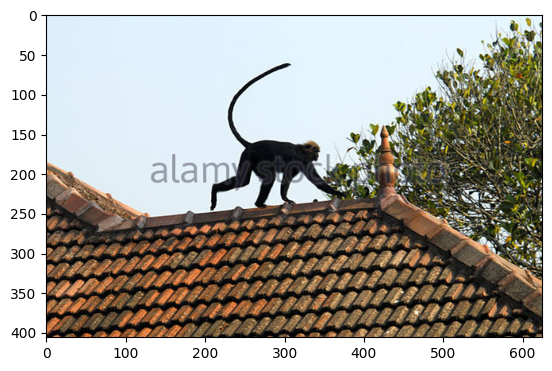

In [32]:
import cv2
from keras.utils.image_utils import load_img, img_to_array
import matplotlib.pyplot as plt

img_path = "data/val/n9/n9130.jpg"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

img = load_img(img_path, target_size=(224, 224))
img = img_to_array(img)
pred = final_model.predict(img[None, ...])[0]
for name, prob in zip(class_indices, pred):
    print(f"{name:<25}: {prob * 100:.2f}%")

This is contrasted with the below image from the training set, where the monkey is much more clearly visible. The model is able to classify the image much more confidently.


Mantled Howler           :  0.03%
Patas Monkey             :  0.00%
Bald Uakari              :  0.00%
Japanese Macaque         :  0.00%
Pygmy Marmoset           :  0.00%
White Headed Capuchin    :  0.00%
Silvery Marmoset         :  0.00%
Common Squirrel Monkey   :  0.00%
Black Headed Night Monkey:  0.00%
Nilgiri Langur           : 99.96%


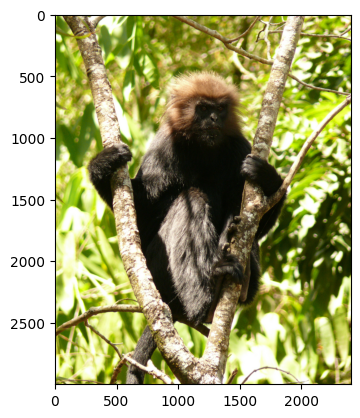

In [33]:
img_path = "data/train/n9/n9046.jpg"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

img = load_img(img_path, target_size=(224, 224))
img = img_to_array(img)
pred = final_model.predict(img[None, ...], verbose=0)[0]
for name, prob in zip(class_indices, pred):
    print(f"{name:<25}: {prob * 100:>5.2f}%")